## Evaluating YOLOv8 for Scalable Environmental Monitoring with Satellite Imagery: a Remote Sensing Workflow

This project evaluates a YOLOv8-based object detection model trained on satellite imagery to assess its suitability for scalable environmental monitoring. Using a dataset of labeled remote sensing images, I tested the model’s ability to classify scenes across diverse land types—such as ports, parking lots, beaches, cities, and forests—achieving an overall mAP@0.5 of 0.760. The workflow supports scalable analysis through batch processing and is designed to inform real-world governance applications in urban planning, coastal monitoring, and infrastructure development.

### Install Required Packages

In [ ]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)


Torch: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import shutil
import pandas as pd

In [ ]:
from ultralytics import YOLO

## Dataset API Setup

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashleylewis1","key":"71d9a0133b8eaf94024142ca4712b693"}'}

In [ ]:
!mkdir -p /root/.config/kaggle
!cp kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()



In [ ]:
# Download the dataset (to current directory)
dataset_name = "umeradnaan/remote-sensing-satellite-images"
download_path = "./remote_sensing"
os.makedirs(download_path, exist_ok=True)

api.dataset_download_files(dataset_name, path=download_path, unzip=True)

# View the downloaded files
print("Downloaded files:")
for root, dirs, files in os.walk(download_path):
    for file in files:
        print(os.path.join(root, file))


Dataset URL: https://www.kaggle.com/datasets/umeradnaan/remote-sensing-satellite-images
Downloaded files:
./remote_sensing/Remote Sensing Data.v2i.yolov8/README.roboflow.txt
./remote_sensing/Remote Sensing Data.v2i.yolov8/README.dataset.txt
./remote_sensing/Remote Sensing Data.v2i.yolov8/data.yaml
./remote_sensing/Remote Sensing Data.v2i.yolov8/train/images/574_jpg.rf.8e857945b38cb82855342f8582ac6353.jpg
./remote_sensing/Remote Sensing Data.v2i.yolov8/train/images/070_jpg.rf.064fa5ad149ec182decf4d63542e7b35.jpg
./remote_sensing/Remote Sensing Data.v2i.yolov8/train/images/437_jpg.rf.a5fcb8701471bf7c6c06caa99de340dc.jpg
./remote_sensing/Remote Sensing Data.v2i.yolov8/train/images/690_jpg.rf.b403259ccb179d8083546dde1fb29bdf.jpg
./remote_sensing/Remote Sensing Data.v2i.yolov8/train/images/606_jpg.rf.2167187427de381697c1b8e033d7728f.jpg
./remote_sensing/Remote Sensing Data.v2i.yolov8/train/images/554_jpg.rf.2dad1f787e788b9acc9d5bc098a4919b.jpg
./remote_sensing/Remote Sensing Data.v2i.yolov8

## Preprocessing


In [ ]:
!ls /content


kaggle.json  remote_sensing  sample_data


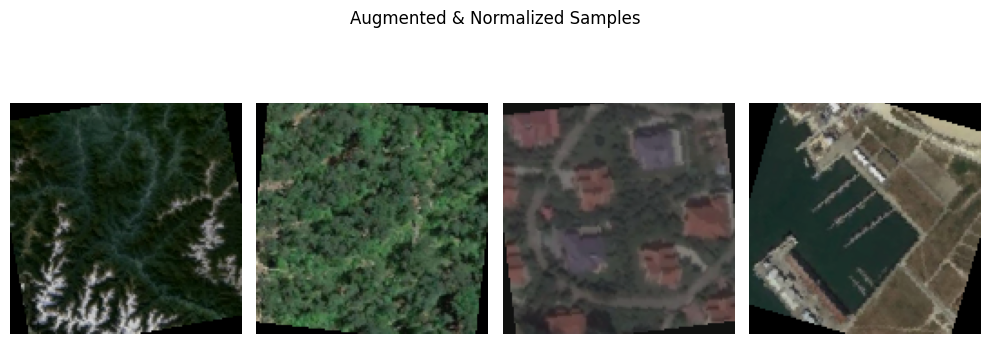

In [ ]:


# Define paths
DATA_DIR = "./remote_sensing"

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to uniform size
    transforms.RandomHorizontalFlip(),  # Flip horizontally with 50% chance
    transforms.RandomVerticalFlip(),    # Flip vertically
    transforms.RandomRotation(20),      # Slight rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),  # Brightness/contrast/saturation
    transforms.ToTensor(),  # Convert to tensor and normalize to [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406],   # Mean for normalization (ImageNet-like)
                         [0.229, 0.224, 0.225])   # Std dev
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# View a batch of transformed images
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)  # Unnormalize
    plt.imshow(img)
    plt.axis('off')

data_iter = iter(dataloader)
images, labels = next(data_iter)

# Plot first 4 images
plt.figure(figsize=(10, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imshow(images[i])
plt.suptitle("Augmented & Normalized Samples")
plt.tight_layout()
plt.show()


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
model = YOLO('yolov8n.pt')
model.train(data='./remote_sensing/Remote Sensing Data.v2i.yolov8/data.yaml', epochs=1)  # just 1 epoch to test structure


Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./remote_sensing/Remote Sensing Data.v2i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

train: Scanning /content/remote_sensing/Remote Sensing Data.v2i.yolov8/train/labels.cache... 700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 700/700 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 108, len(boxes) = 816. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 394.0±215.5 MB/s, size: 38.5 KB)


val: Scanning /content/remote_sensing/Remote Sensing Data.v2i.yolov8/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 19, len(boxes) = 230. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


WARNING ⚠️ 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.01G     0.8696      3.878      1.401         46        640:   5%|▍         | 2/44 [00:03<01:05,  1.57s/it]


KeyboardInterrupt: 

## Modeling: Land Use Classification

In [ ]:
torch.cuda.empty_cache()
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
# Load a pre-trained YOLOv8 model
model = YOLO("yolov8n.pt")  # 'n' = nano, fastest; 's' = small; 'm', 'l', 'x' are larger

# Train the model
model.train(data="./remote_sensing/Remote Sensing Data.v2i.yolov8/data.yaml", epochs=50, batch=8)


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./remote_sensing/Remote Sensing Data.v2i.yolov8/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

train: Scanning /content/remote_sensing/Remote Sensing Data.v2i.yolov8/train/labels... 700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 700/700 [00:00<00:00, 1908.56it/s]

train: New cache created: /content/remote_sensing/Remote Sensing Data.v2i.yolov8/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 108, len(boxes) = 816. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 804.9±440.8 MB/s, size: 38.5 KB)


val: Scanning /content/remote_sensing/Remote Sensing Data.v2i.yolov8/valid/labels... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 2166.29it/s]

val: New cache created: /content/remote_sensing/Remote Sensing Data.v2i.yolov8/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 19, len(boxes) = 230. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.13G     0.5635      3.557      1.274         14        640: 100%|██████████| 88/88 [00:18<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]

                   all        200        230     0.0111      0.858      0.095     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.39G     0.4556       2.92      1.213         11        640: 100%|██████████| 88/88 [00:14<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.84it/s]

                   all        200        230      0.602      0.271      0.252       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.41G     0.4856      2.542      1.219         16        640: 100%|██████████| 88/88 [00:14<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.17it/s]

                   all        200        230      0.621      0.354      0.393      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.43G     0.4455      2.282      1.189         17        640: 100%|██████████| 88/88 [00:15<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.55it/s]

                   all        200        230      0.507      0.449      0.473      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.45G     0.4244      2.119      1.178         13        640: 100%|██████████| 88/88 [00:14<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.86it/s]

                   all        200        230      0.482      0.508      0.506      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.46G     0.4283      2.066      1.169         14        640: 100%|██████████| 88/88 [00:15<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.13it/s]

                   all        200        230      0.507      0.497      0.528      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.48G     0.4236      1.955      1.166         12        640: 100%|██████████| 88/88 [00:14<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.78it/s]


                   all        200        230      0.588      0.536      0.537      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       1.5G     0.3664      1.826       1.12         16        640: 100%|██████████| 88/88 [00:14<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.21it/s]

                   all        200        230      0.437      0.577      0.562      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.52G     0.3855      1.795      1.136         14        640: 100%|██████████| 88/88 [00:14<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.17it/s]

                   all        200        230      0.538      0.585      0.567      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.53G     0.3763       1.71      1.134         11        640: 100%|██████████| 88/88 [00:15<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.32it/s]


                   all        200        230      0.569       0.61      0.607      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.55G     0.3497      1.696      1.117          9        640: 100%|██████████| 88/88 [00:14<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.71it/s]

                   all        200        230      0.699      0.501      0.587      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.56G      0.357       1.64      1.135         11        640: 100%|██████████| 88/88 [00:14<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.19it/s]

                   all        200        230      0.561      0.578      0.608       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.58G     0.3497       1.58      1.105         12        640: 100%|██████████| 88/88 [00:14<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.22it/s]

                   all        200        230      0.518        0.6      0.616      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       1.6G     0.3378      1.558      1.093         12        640: 100%|██████████| 88/88 [00:14<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.10it/s]

                   all        200        230      0.599      0.656      0.637      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.62G     0.3322      1.516      1.088         12        640: 100%|██████████| 88/88 [00:15<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]

                   all        200        230       0.59       0.64      0.635      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.63G     0.3221      1.479      1.075         17        640: 100%|██████████| 88/88 [00:14<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.96it/s]

                   all        200        230      0.624      0.588      0.632      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.65G     0.3104      1.419      1.077         13        640: 100%|██████████| 88/88 [00:14<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.28it/s]

                   all        200        230      0.633      0.614      0.668       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.67G     0.3208      1.446      1.088         16        640: 100%|██████████| 88/88 [00:14<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]

                   all        200        230      0.662      0.617      0.689      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.69G     0.3028      1.383      1.071         16        640: 100%|██████████| 88/88 [00:14<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.20it/s]

                   all        200        230      0.663      0.574      0.653      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       1.7G     0.3254      1.368      1.097         16        640: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.20it/s]

                   all        200        230        0.7      0.599      0.688      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.72G     0.2876      1.304       1.06         13        640: 100%|██████████| 88/88 [00:14<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.35it/s]

                   all        200        230       0.65      0.615      0.668      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.74G     0.2995      1.347      1.071         12        640: 100%|██████████| 88/88 [00:13<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]


                   all        200        230      0.677      0.632      0.684      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.75G     0.2916      1.282      1.071         16        640: 100%|██████████| 88/88 [00:14<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.16it/s]

                   all        200        230      0.694      0.661      0.693      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.77G     0.2983      1.277      1.072          9        640: 100%|██████████| 88/88 [00:14<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]

                   all        200        230      0.627      0.622      0.674      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.79G     0.2812      1.216      1.046          9        640: 100%|██████████| 88/88 [00:13<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.25it/s]

                   all        200        230      0.754      0.633      0.691      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       1.8G     0.2914      1.206      1.061         14        640: 100%|██████████| 88/88 [00:13<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.56it/s]


                   all        200        230      0.693      0.644      0.696       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.82G     0.2757       1.16       1.05         14        640: 100%|██████████| 88/88 [00:14<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.73it/s]

                   all        200        230      0.692      0.683      0.713      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.84G     0.2689      1.195      1.041         13        640: 100%|██████████| 88/88 [00:14<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.28it/s]

                   all        200        230      0.659      0.662      0.695      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.86G     0.2786      1.174      1.058         10        640: 100%|██████████| 88/88 [00:14<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.18it/s]

                   all        200        230      0.769       0.65      0.729      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.88G     0.2758      1.158      1.051         15        640: 100%|██████████| 88/88 [00:15<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        200        230      0.808      0.632      0.722      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.89G     0.2817      1.139      1.062         17        640: 100%|██████████| 88/88 [00:14<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.19it/s]

                   all        200        230      0.724      0.626      0.709      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.91G     0.2696      1.121      1.045         14        640: 100%|██████████| 88/88 [00:14<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.07it/s]

                   all        200        230      0.742      0.626      0.713      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.92G     0.2479      1.107       1.03         10        640: 100%|██████████| 88/88 [00:13<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.27it/s]

                   all        200        230      0.778      0.621      0.707       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.94G     0.2552      1.098      1.021         12        640: 100%|██████████| 88/88 [00:13<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.50it/s]

                   all        200        230      0.811      0.609        0.7       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.96G     0.2607      1.055      1.043         10        640: 100%|██████████| 88/88 [00:13<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.19it/s]

                   all        200        230      0.724      0.689      0.733      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.98G     0.2592       1.05      1.037         15        640: 100%|██████████| 88/88 [00:13<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.37it/s]


                   all        200        230      0.729      0.696       0.73      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.99G     0.2582       1.05      1.035          7        640: 100%|██████████| 88/88 [00:13<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


                   all        200        230      0.761      0.658      0.733      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.01G     0.2447       1.03       1.03         17        640: 100%|██████████| 88/88 [00:13<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.74it/s]

                   all        200        230      0.701       0.71      0.745      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.03G     0.2311      1.008      1.025         12        640: 100%|██████████| 88/88 [00:15<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.57it/s]

                   all        200        230      0.791       0.66      0.746      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.04G     0.2186      1.008      1.005         17        640: 100%|██████████| 88/88 [00:13<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.46it/s]

                   all        200        230      0.773      0.669       0.75      0.683


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.06G     0.3135      1.392      1.159          4        640: 100%|██████████| 88/88 [00:14<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.24it/s]

                   all        200        230      0.798      0.663      0.746      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.07G     0.2805       1.14      1.121          4        640: 100%|██████████| 88/88 [00:13<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.04it/s]


                   all        200        230      0.778      0.663       0.75      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.09G     0.2482      1.051      1.102          4        640: 100%|██████████| 88/88 [00:13<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]

                   all        200        230      0.708      0.704      0.747      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.11G     0.2498      1.025      1.074          4        640: 100%|██████████| 88/88 [00:13<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.23it/s]

                   all        200        230      0.802      0.689      0.755      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.13G     0.2457      1.009      1.072          6        640: 100%|██████████| 88/88 [00:13<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.10it/s]

                   all        200        230      0.791      0.675      0.761      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.14G     0.2322     0.9482      1.075          4        640: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


                   all        200        230      0.756      0.702      0.759      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.16G     0.2324     0.9683       1.07          4        640: 100%|██████████| 88/88 [00:13<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.26it/s]

                   all        200        230      0.796      0.659      0.757      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.18G     0.2268     0.9246      1.074          4        640: 100%|██████████| 88/88 [00:13<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.31it/s]


                   all        200        230      0.748      0.688      0.751      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.2G     0.2336     0.9147      1.066          5        640: 100%|██████████| 88/88 [00:13<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


                   all        200        230      0.758      0.691      0.758      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.21G     0.2331     0.9003      1.064          4        640: 100%|██████████| 88/88 [00:13<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.32it/s]

                   all        200        230      0.769      0.692       0.76      0.687



50 epochs completed in 0.229 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.38it/s]


                   all        200        230      0.794      0.675       0.76      0.694
           Agriculture         15         15       0.77      0.667      0.775      0.771
               Airport         13         13      0.692       0.69      0.717      0.717
                 Beach         11         11      0.899       0.81      0.955      0.924
                  City         39         39      0.841      0.795      0.874      0.847
                Desert         16         16      0.911      0.625      0.753      0.747
                Forest         12         13      0.652      0.385      0.452      0.428
             Grassland         23         23      0.598      0.517      0.646      0.625
               Highway         15         15      0.907      0.467      0.713      0.535
                  Lake         17         17      0.886      0.765      0.787       0.52
              Mountain         19         19      0.881      0.789      0.865      0.865
               Parkin

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dffd195d750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

## Evaluate Model

In [ ]:
# Load model
model = YOLO("runs/detect/train2/weights/best.pt")

# Run evaluation on validation set
metrics = model.val()

# Print results
print(metrics)


Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 875.9±286.7 MB/s, size: 44.0 KB)


val: Scanning /content/remote_sensing/Remote Sensing Data.v2i.yolov8/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 19, len(boxes) = 230. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


                   all        200        230      0.792      0.675       0.76      0.695
           Agriculture         15         15       0.77      0.667      0.775      0.771
               Airport         13         13      0.691      0.689      0.718      0.718
                 Beach         11         11      0.898      0.804      0.955      0.924
                  City         39         39      0.841      0.795      0.874      0.848
                Desert         16         16      0.911      0.625      0.753      0.748
                Forest         12         13      0.652      0.385      0.452      0.428
             Grassland         23         23      0.598      0.518      0.645      0.624
               Highway         15         15      0.904      0.467      0.714      0.536
                  Lake         17         17      0.884      0.765      0.787       0.52
              Mountain         19         19      0.881      0.789      0.865      0.865
               Parkin

In [ ]:
print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)
print("Precision:", metrics.box.p)
print("Recall:", metrics.box.r)
print("F1 Score:", metrics.box.f1)

mAP@0.5: 0.7604267945899392
mAP@0.5:0.95: 0.6945400879853616
Precision: [    0.77039     0.69122      0.8983     0.84071     0.91083     0.65196     0.59805     0.90445     0.88396     0.88088     0.82254           1      0.6372      0.5976]
Recall: [    0.66667     0.68906     0.80423     0.79487       0.625     0.38462     0.51771     0.46667     0.76471     0.78947     0.92736     0.88501        0.75     0.38462]
F1 Score: [    0.71478     0.69014     0.84866     0.81715     0.74132     0.48381     0.55499     0.61567     0.82002     0.83267     0.87181       0.939     0.68901     0.46802]


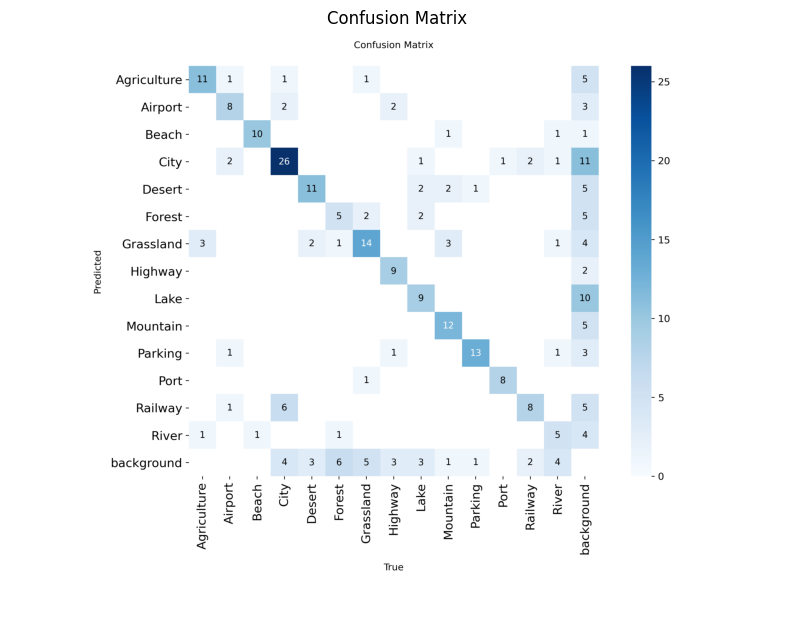

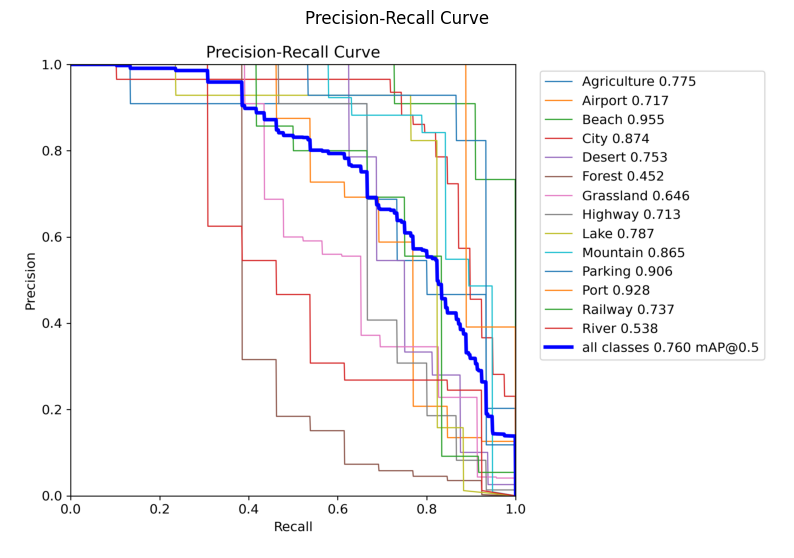

In [ ]:
import cv2

# Example file path
image_path = "runs/detect/train2/confusion_matrix.png"

# Load image with OpenCV (loads as BGR)
img = cv2.imread(image_path)

# Convert BGR to RGB for matplotlib display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Confusion Matrix")
plt.show()

# Example file path
image_path = "runs/detect/train2/BoxPR_curve.png"

# Load image with OpenCV (loads as BGR)
img = cv2.imread(image_path)

# Convert BGR to RGB for matplotlib display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Precision-Recall Curve")
plt.show()


The model achieved an overall mean Average Precision (mAP@0.5) of 0.760, indicating solid detection performance across multiple land use classes.

The model excels in detecting beach, parking, and port areas with high precision and recall (~0.9), suggesting strong feature differentiation for these classes.

Performance is good for city and mountain (~0.8), reflecting effective recognition of urban and rugged terrain.

Moderate detection quality is observed for airport, desert highway, lake, and railway (~0.7), indicating room for improvement possibly due to variability or complexity in these classes.

The model shows acceptable but lower precision-recall for grassland (~0.6), while river and forest classes lag behind (≤0.5), suggesting these environments are more challenging to classify.

Classes such as river and forest show lower TP counts (confusion matrix), consistent with their lower PR scores, which may reflect class overlap or ambiguous visual features.

These misclassifications highlight the need for further feature engineering or inclusion of auxiliary data (e.g., multispectral bands, temporal context) to improve discrimination in challenging classes.

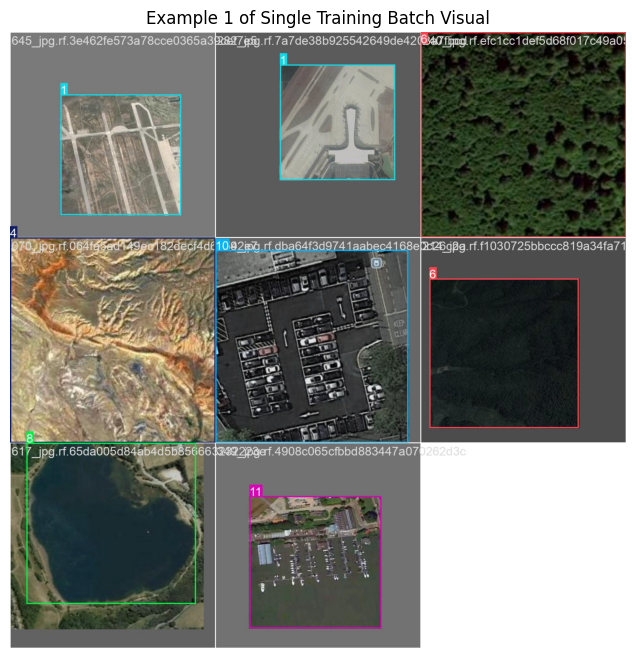

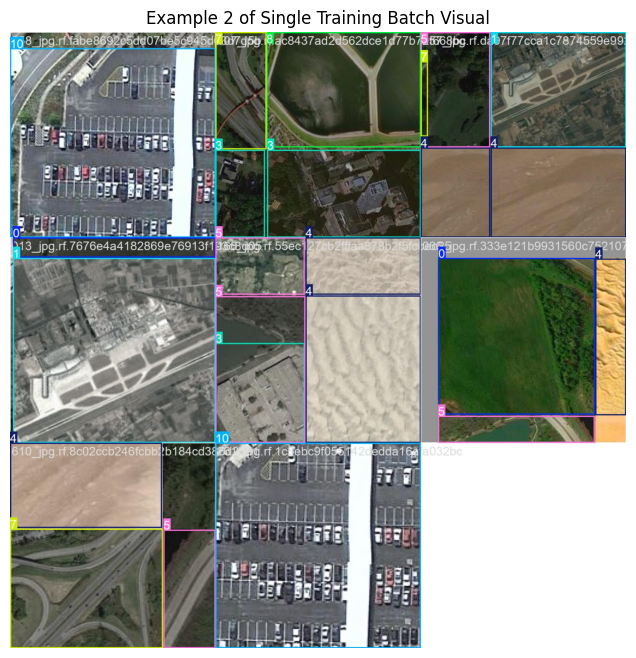

In [ ]:
# Example file path
image_path = "runs/detect/train2/train_batch3520.jpg"

# Load image with OpenCV (loads as BGR)
img = cv2.imread(image_path)

# Convert BGR to RGB for matplotlib display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Example 1 of Single Training Batch Visual")
plt.show()

# Example file path
image_path = "runs/detect/train2/train_batch2.jpg"

# Load image with OpenCV (loads as BGR)
img = cv2.imread(image_path)

# Convert BGR to RGB for matplotlib display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Example 2 of Single Training Batch Visual")
plt.show()


Visualizing bounding boxes on images helps to highlight which parts of the image the model focuses on for its predictions.

## Scalability and Development

This pipeline is designed for scalability, capable of processing large batches of satellite images or integrating with streaming satellite feeds for near-real-time analysis. The YOLOv8-based model architecture allows fast inference on high-resolution imagery, making it feasible to monitor hundreds or even thousands of regions simultaneously. With optimized data loading and GPU acceleration, this system can be deployed across cloud or edge infrastructure to support continuous environmental surveillance at scale.

The model demonstrates strong performance in detecting land use types such as beach, parking lots, ports, cities, and mountainous areas—all of which are critical zones for environmental governance. Outputs from this pipeline could inform coastal erosion monitoring (beaches), urban sprawl detection (cities), or infrastructure expansion (ports, parking). For example, consistent detection of unregulated port development or illegal mountain deforestation could trigger policy reviews or enforcement actions. By converting raw satellite imagery into actionable insights, this AI system offers a practical tool for decision-makers in climate adaptation, land use regulation, and sustainable development planning.